In [1]:
from google.colab import drive
from pathlib import Path
from PIL import Image
import requests

import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

# import GLCM tools
from skimage.feature import graycomatrix, graycoprops
from skimage import data
from skimage.color import rgb2gray

In [2]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def display_images(image_dict):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 1, 1 for test
    fig.tight_layout()

    for i, (title, image) in enumerate(image_dict.items()):
        row = i // 3
        col = i % 3
        axes[row, col].imshow(image)
        axes[row, col].set_title(title)
        axes[row, col].axis("off")

    plt.show()

def brighten(band: np.ndarray):
    """Adjust image brightness using an alpha value (0 to 1). Higher alpha increases brightness, lower decreases."""

    alpha=0.2 # you can change this value
    beta=0
    return np.clip(alpha*band+beta, 0,255)

def normalize(band: np.ndarray) -> np.ndarray:
    """
    First brighten the bands and then return normalized image
    """
    band = brighten(band)
    band_min, band_max = (band.min(), band.max())

    return ((band-band_min)/((band_max - band_min)))

def display_transformed_images(data_path: Path):
    """
    Generate Sentinel-2 images from the given filepath. The returned images are as follows:
       NDVI: Normalized Difference Vegetation Index
       NDVI705: Normalized Difference Vegetation Index (705m)
       NDBI: Normalized Difference Built-up Index
       NDWI: Normalized Difference Water Index
       False Color: B08, B04, B03
       Mask: The class labels for each pixel

    Please Note: If the size of the input

    Note: If the input tile contains 0 values (ie. black squares in the tiles),
      a warning will be printed due to division by zero.
    """
    # Unpack the bands
    band_size = tiff.imread(f"{data_path}/B02.tiff").shape
    print(band_size)

    B02 = normalize(
            tiff.imread(f"{data_path}/B02.tiff"),)
    B03 = normalize(
            tiff.imread(f"{data_path}/B03.tiff"),)
    B04 = normalize(
            tiff.imread(f"{data_path}/B04.tiff"),)
    B05 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B05.tiff"),
                band_size[::-1]# make sure the dimensions of B11 is the same as the other bands after resizing
            ))
    B08 = normalize(
            tiff.imread(f"{data_path}/B08.tiff"),)

    B11 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B11.tiff"),
                band_size[::-1]# make sure the dimensions of B11 is the same as the other bands after resizing
            ))

    B12 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B12.tiff"),
                band_size[::-1]
            ))

    # Calculate NDVI (Normalized Difference Vegetation Index)
    NDVI = (B08 - B04) / (B08 + B04)

    # Calculate NDVI705
    NDVI705 = (B05 - B04) / (B05 + B04)

    # Calculate NDBI (Normalized Difference Built-Up Index)
    NDBI = (B11 - B08) / (B11 + B08)

    # # Calculate NDWI (Normalized Difference Water Index)
    NDWI = (B08 - B12) / (B08 + B12)

    # # Calculate NBR (Normalized Burn Ratio)
    NBR = (B08 - B12) / (B08 + B12)

    # Create a color image using RGB bands
    RGB = np.stack([B04, B03, B02], axis=-1)
    # save the RGB image to Google Drive
    # Normalize the image to the range [0, 255] and convert to uint8

    images = {
        "NDVI": NDVI,
        "NDVI705": NDVI705,
        "NDBI": NDBI,
        "NDWI": NDWI,
        "NBR": NBR,
        "RGB": RGB,
        # "False Color": false_color,
    }

    display_images(images)

    return images

(740, 1439)


<ipython-input-3-f570a9a818e3>:76: RuntimeWarning: invalid value encountered in divide
  NDVI = (B08 - B04) / (B08 + B04)
<ipython-input-3-f570a9a818e3>:79: RuntimeWarning: invalid value encountered in divide
  NDVI705 = (B05 - B04) / (B05 + B04)
<ipython-input-3-f570a9a818e3>:82: RuntimeWarning: invalid value encountered in divide
  NDBI = (B11 - B08) / (B11 + B08)
<ipython-input-3-f570a9a818e3>:85: RuntimeWarning: invalid value encountered in divide
  NDWI = (B08 - B12) / (B08 + B12)
<ipython-input-3-f570a9a818e3>:88: RuntimeWarning: invalid value encountered in divide
  NBR = (B08 - B12) / (B08 + B12)


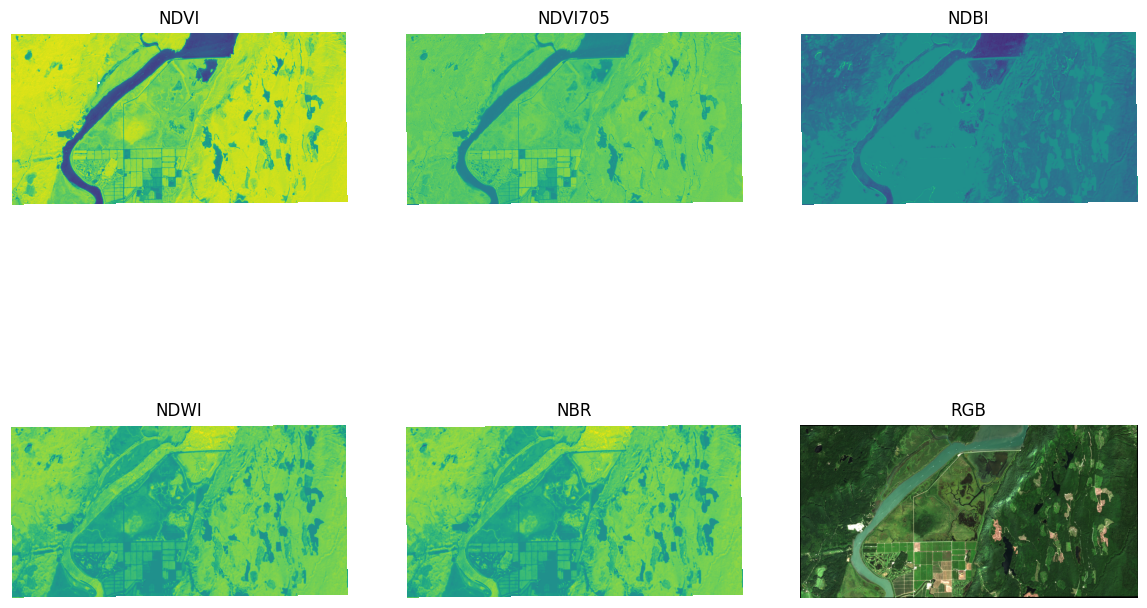

In [4]:
cropped_tile_path = "/content/drive/MyDrive/pitt_cropped"  # TODO put the path to the tile here

images = display_transformed_images(cropped_tile_path)

In [5]:
# Convert PIL Image to NumPy array
gt = Image.open('/content/pitt_meadows.tif')
gt_array = np.array(gt)

NDVI = images["NDVI"]
RGB = images["RGB"]

# Abadon resizing original RGB and NDVI due to loss of accuracy
# # Resize NDVI and RGB to match the ground truth data  identification result
# resized_ndvi = cv2.resize(NDVI, (gt_array.shape[1], gt_array.shape[0]))
# resized_rgb = cv2.resize(image, (gt_array.shape[1], gt_array.shape[0]))
# print("Ground truth shape: ", gt_array.shape)
# print("Resized NDVI shape", resized_ndvi.shape)
# print("Resized RGB shape", resized_rgb.shape)

In [12]:
# Define the number of levels
levels = 128
# Define the patch_size
patch_size = 20

# Convert to grayscale
gray_image = rgb2gray(RGB)
gray_image = (gray_image * (levels - 1)).astype(np.uint8)  # Scale to uint8

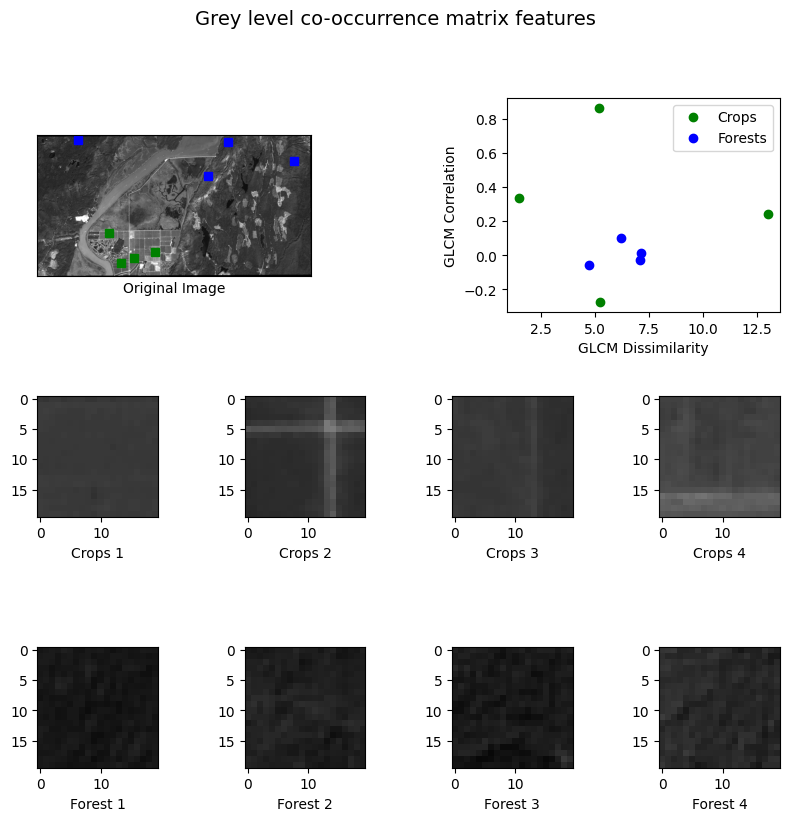

In [16]:
# select some patches from crop fields areas of the image
crops_locations = [(508,368), (662,430), (638,500), (606,610)]
crops_patches = []
for loc in crops_locations:
    crops_patches.append(
        gray_image[loc[0] : loc[0] + patch_size, loc[1] : loc[1] + patch_size]
    )

# select some patches from forest areas of the image
forest_locations = [(16, 204), (28,995), (128,1339), (208,886)]
forest_patches = []
for loc in forest_locations:
    forest_patches.append(
        gray_image[loc[0] : loc[0] + patch_size, loc[1] : loc[1] + patch_size]
    )

# compute some GLCM properties each patch
xs = []
ys = []
for patch in crops_patches + forest_patches:
    glcm = graycomatrix(
        patch, distances=[5], angles=[0], levels=levels, symmetric=True, normed=True
    )
    xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(graycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(gray_image, cmap=plt.cm.gray, vmin=0, vmax=(levels-1))
for y, x in crops_locations:
    ax.plot(x + patch_size / 2, y + patch_size / 2, 'gs')
for y, x in forest_locations:
    ax.plot(x + patch_size / 2, y + patch_size / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[: len(crops_patches)], ys[: len(crops_patches)], 'go', label='Crops')
ax.plot(xs[len(crops_patches) :], ys[len(crops_patches) :], 'bo', label='Forests')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(crops_patches):
    ax = fig.add_subplot(3, len(crops_patches), len(crops_patches) * 1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
    ax.set_xlabel(f"Crops {i + 1}")

for i, patch in enumerate(forest_patches):
    ax = fig.add_subplot(3, len(forest_patches), len(forest_patches) * 2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, vmin=0, vmax=255)
    ax.set_xlabel(f"Forest {i + 1}")


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

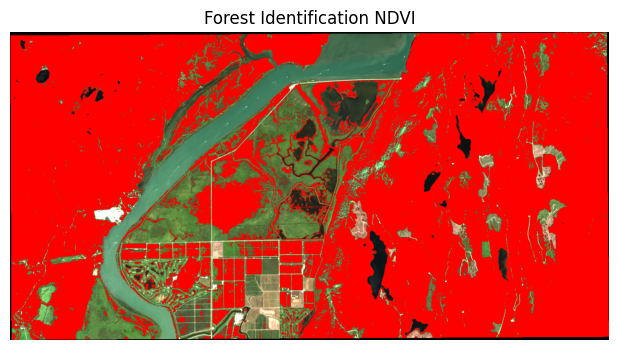

In [14]:
ndvi_mask = NDVI > 0.585

forest_ndvi = RGB.copy()
for i in range(RGB.shape[0]):
    for j in range(RGB.shape[1]):
        if ndvi_mask[i, j]:
            forest_ndvi[i, j] = [255, 0, 0]  # Mark forest pixels in red

# Display the results
plt.figure(figsize=(8, 4))
plt.imshow(forest_ndvi)
plt.title("Forest Identification NDVI")
plt.axis('off')
plt.show()


In [17]:
dissimilarity_map = np.zeros(gray_image.shape, dtype=np.float32)
correlation_map = np.zeros(gray_image.shape, dtype=np.float32)

# Sliding window computation
for i in range(0, gray_image.shape[0] - patch_size + 1):
    for j in range(0, gray_image.shape[1] - patch_size + 1):
        if ndvi_mask[i + patch_size // 2, j + patch_size // 2]:
            patch = gray_image[i:i + patch_size, j:j + patch_size]
            glcm = graycomatrix(
                patch, distances=[5], angles=[0], levels=levels, symmetric=True, normed=True
            )
            dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]

            # Store the properties in maps
            dissimilarity_map[i + patch_size // 2, j + patch_size // 2] = dissimilarity
            correlation_map[i + patch_size // 2, j + patch_size // 2] = correlation


In [50]:
# Create masks based on thresholds
# Use numpy array operations to create a boolean mask
# Define GLCM thresholds
DISSIMILARITY_RANGE = [2.5,10]
CORRELATION_RANGE = [-0.4, 0.4]

forest_mask = (
    (DISSIMILARITY_RANGE[0] <= dissimilarity_map)
    & (dissimilarity_map <= DISSIMILARITY_RANGE[1])
    & (CORRELATION_RANGE[0] <= correlation_map)
    & (correlation_map <= CORRELATION_RANGE[1])
)

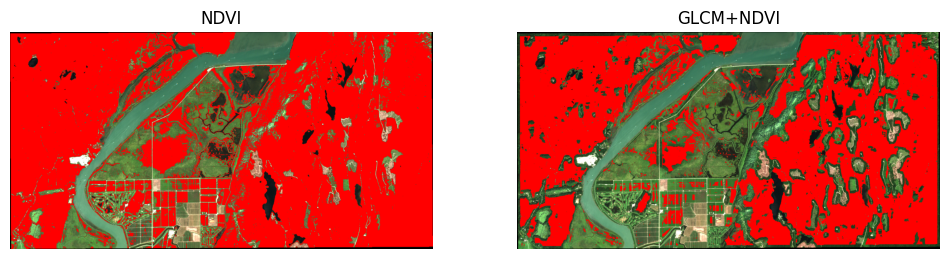

In [51]:
# Apply the masks
forest_glcm = RGB.copy()
for i in range(RGB.shape[0]):
    for j in range(RGB.shape[1]):
        if forest_mask[i, j]:
            forest_glcm[i, j] = [255, 0, 0]  # Mark forest pixels in red

# Display the mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("NDVI")
plt.imshow(forest_ndvi)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("GLCM+NDVI")
plt.imshow(forest_glcm)
plt.axis('off')

plt.show()

In [32]:
# resize gt
gt_array = cv2.resize(gt_array, (images["RGB"].shape[1], images["RGB"].shape[0]))

In [33]:
# determine the accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# unclassified
ignore_vals = [[104,104,104]]
# Wetland-treed #9933cc->[153, 51, 204], Coniferous #006600->[0, 102, 0], Broadleaf #00cc00->[0,204,0], Mixedwood #cc9900->[204, 153, 0]
tree_vals = [[153, 51, 204], [0, 102, 0], [0, 204, 0], [204, 153,0]]

truth = []

rows, cols, _ = gt_array.shape

for i in range(rows):
    for j in range(cols):
        truth_pixel = [gt_array[i][j][0], gt_array[i][j][1], gt_array[i][j][2]]
        if truth_pixel in ignore_vals:
            continue
        if truth_pixel in tree_vals:
            truth.append(1)
        else:
            truth.append(0)

GLCM accuracy:  0.7750352158969254


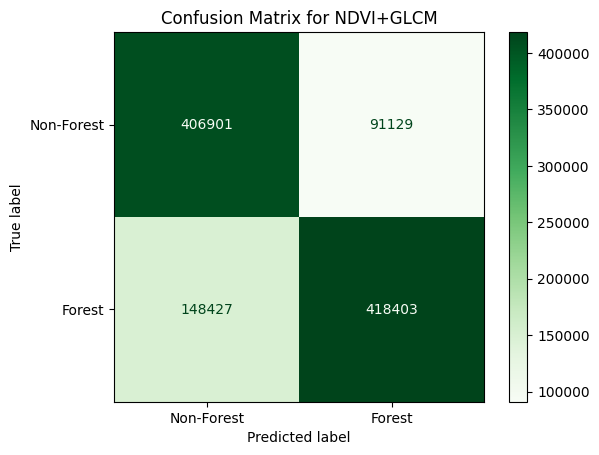

In [52]:
glcm_predictions = []

for i in range(rows):
  for j in range(cols):
     # Add forest identification (from algorithm) to predictions
        forest_pixel = [forest_glcm[i][j][0], forest_glcm[i][j][1], forest_glcm[i][j][2]]
        if forest_pixel == [255, 0, 0]:
            glcm_predictions.append(1)
        else:
            glcm_predictions.append(0)

# Create confusion matrices
cm_forest_glcm = confusion_matrix(truth, glcm_predictions)
print("GLCM accuracy: ", accuracy_score(truth, glcm_predictions))


# Display the confusion matrices
display_forest = ConfusionMatrixDisplay(confusion_matrix=cm_forest_glcm, display_labels=['Non-Forest', 'Forest'])
display_forest.plot(values_format='', cmap='Greens')
plt.title("Confusion Matrix for NDVI+GLCM")
plt.show()

In [53]:
# Extract TP, FP, FN, and TN
TP = cm_forest_glcm[0, 0]
FP = cm_forest_glcm[0, 1]
FN = cm_forest_glcm[1, 0]
TN = cm_forest_glcm[1, 1]

# Calculate Recall
recall = TP / (TP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"GLCM Recall: {recall}")
print(f"GLCM Precision: {precision}")
print(f"GLCM F1 Score: {f1_score}")

GLCM Recall: 0.7327219228996197
GLCM Precision: 0.8170210629881735
GLCM F1 Score: 0.7725787434091733
